In [1]:
from scipy.signal import find_peaks, peak_widths
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lmfit import Model
from lmfit.models import LinearModel, GaussianModel, ExponentialModel, ConstantModel, PowerLawModel, PolynomialModel, LorentzianModel, VoigtModel
from lmfit.model import save_modelresult, load_modelresult

In [39]:
df = pd.read_csv(r"/Users/benkupernk/Documents/GitHub/XRD-Fitting/fit_9.csv")
df = df[(df['q'] >= (q_min := 1.75)) & (df['q'] <= (q_max := 1.9))]
df.plot(x='q', y='I')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/benkupernk/Documents/GitHub/XRD-Fitting/fit_9.csv'

<AxesSubplot:xlabel='q'>

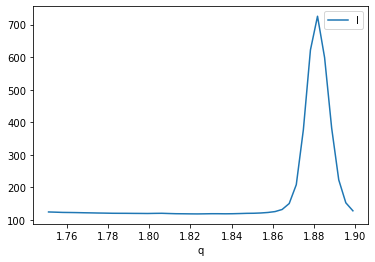

In [28]:
df.plot(x='q', y='I')

In [22]:
class Model_dict():
    def __init__(self):
        self.main_dict = {}
        
    def add_model (self, keys_list, vals_list):
            i = str(len(self.main_dict.keys()))
            model_name = 'model_%s' % i
            self.main_dict[model_name] = {}
            
            for key, val in zip(keys_list, vals_list):
                self.main_dict[model_name][key] = val
                
    def order_by_val(self, val = 'amplitudes'):
        for model in self.main_dict.values():
            if val in model.keys():
                sort_idx = list(np.argsort(model.get(val)))
                sort_idx.reverse()
            for key, val in model.items():
                model[key] = [val[i] for i in sort_idx]
                
            

        

{'model_0': {'centers': array([1.78588854, 1.82369461, 1.85806328]), 'sigmas': array([0.00371811, 0.00342884, 0.00828764]), 'amplitudes': array([ 1.95183563,  1.1120224 , 64.89470673])}}


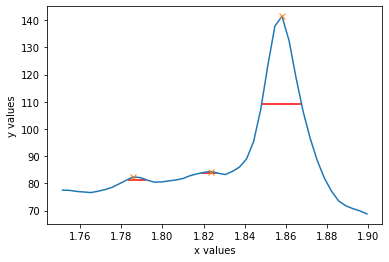

In [23]:
def index_to_xdata(xdata, indices):
    "interpolate the values from signal.peak_widths to xdata"
    ind = np.arange(len(xdata))
    f = interp1d(ind,xdata)
    return f(indices)

x = np.array(df.q)
y = np.array(df.I)

peak_vals = {}

peaks, vals = find_peaks(y, height = .1, prominence = .1)
widths, width_heights, left_ips, right_ips = peak_widths(y, peaks)

widths = index_to_xdata(x, widths)
left_ips = index_to_xdata(x, left_ips)
right_ips = index_to_xdata(x, right_ips)

keys_list = ['centers', 'sigmas', 'amplitudes']

vals_list = [np.array(np.take(x, peaks)), np.array((right_ips - left_ips)/2.35),np.array(vals['prominences'])]
peak_vals = Model_dict()
peak_vals.add_model(keys_list, vals_list)


print(peak_vals.main_dict)
plt.plot(x,y)
plt.plot(x[peaks], y[peaks], "x")
plt.hlines(width_heights, left_ips, right_ips, color='r')
plt.xlabel('x values')
plt.ylabel('y values')
plt.show()


In [24]:
peak_vals.order_by_val()
peak_vals.main_dict

[ 1.95183563  1.1120224  64.89470673]
[2, 0, 1]
centers [1.8580632839033373, 1.7858885397142743, 1.8236946066408013]
sigmas [0.008287637601642939, 0.0037181060427674524, 0.003428841455974379]
amplitudes [64.89470672607423, 1.9518356323242045, 1.112022399902358]


{'model_0': {'centers': [1.8580632839033373,
   1.7858885397142743,
   1.8236946066408013],
  'sigmas': [0.008287637601642939,
   0.0037181060427674524,
   0.003428841455974379],
  'amplitudes': [64.89470672607423, 1.9518356323242045, 1.112022399902358]}}

In [15]:
peak_vals.main_dict

{'model_0': {'centers': array([1.78588854, 1.82369461, 1.85806328]),
  'sigmas': array([0.00371811, 0.00342884, 0.00828764]),
  'amplitudes': array([ 1.95183563,  1.1120224 , 64.89470673])}}

In [ ]:
background = LinearModel(prefix=('b' + '_'))  
pars = background.make_params()

model = background

# TODO make this better initial guesses     
slope1 = 0 
int1 = 50

# For linear background
pars = background.make_params()
pars['b' + '_slope'].set(slope1)
pars['b' + '_intercept'].set(int1)

for i in range(len(peak_vals.values())):
    center = peak_vals['centers'][i]
    sigma = peak_vals['sigmas'][i]
    amplitude = peak_vals['amplitudes'][i]
    
    # create prefex for each peak
    pref = 'v'+str(i)+'_'   
    peak = VoigtModel(prefix=pref)
    
    # set the parimiters for each peak
    pars.update(peak.make_params())
    peak = VoigtModel(prefix=pref)
    pars[pref+'center'].set(value=center, min= center - 0.025, max= center + 0.025)
    pars[pref+'sigma'].set(value=sigma, max = sigma * 5)
    pars[pref+'amplitude'].set(amplitude, min = 0)
    pars[pref+'gamma'].set(value=sigma, vary=True, expr='', min = 0)
    
    model += peak

# for peak, center in enumerate(model_centers):
#     # create prefex for each peak
#     pref = 'v'+str(peak)+'_'
#     #peak = GaussianModel(prefix=pref)
#     peak = VoigtModel(prefix=pref)
#     # set the parimiters for each peak
#     pars.update(peak.make_params())
#     #pars[pref+'center'].set(value=center, min=q_min, max=q_max)
#     pars[pref+'center'].set(value=center, min= center - 0.025, max= center + 0.025)
#     pars[pref+'sigma'].set(value=sig, max = sig * 5)
#     pars[pref+'amplitude'].set(amp, min = 0)
#     pars[pref+'gamma'].set(value=sig, vary=True, expr='', min = 0)

#     model = model + peak

In [ ]:
model